In [ ]:
# Import packages
import pandas as pd
import numpy as np
import gdown
import json
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input

# <center>Download the mereged data from Google Drive

In [3]:
merged_data_file_id = '1o_EEumVnswul9MVsrdDwBch5rt7JTr0m'
merged_data_url = f'https://drive.google.com/uc?id={merged_data_file_id}'
output = '../../temporary_files/merged.csv'
gdown.download(merged_data_url, output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1o_EEumVnswul9MVsrdDwBch5rt7JTr0m
To: c:\Users\Steven\Documents\Projects\ss24-capstone-team23-datallah-nkitts-steveso\temporary_files\merged.csv
100%|██████████| 438k/438k [00:00<00:00, 6.91MB/s]


'../../temporary_files/merged.csv'

# <h1><center>Test Different Window Size</center></h1>

In [6]:
# Load merged data into DataFrame
merged_df = pd.read_csv('../../temporary_files/merged.csv')
merged_df.columns

Index(['City', 'Date', 'ZHVI', 'NewHomePermits', 'Population_In_Housing_Units',
       'Owner_Occupied_Population', 'Renter-Occupied-Population',
       'OOP_Moved_From_Different_County', 'OOP_Moved_From_Different_State',
       'OOP_Moved_From_Abroad', 'ROP_Moved_From_Different_County',
       'ROP_Moved_From_Different_State', 'ROP_Moved_From_Abroad',
       'PropertyCrimeIncident', 'ViolentCrimeIncident',
       'cargo_domestic_outbound', 'cargo_domestic_inbound',
       'passenger_domestic_outbound', 'passenger_domestic_inbound',
       'cargo_intl_outbound', 'cargo_intl_inbound', 'passenger_intl_outbound',
       'passenger_intl_inbound', 'dem_senate_cnt', 'rep_senate_cnt',
       'dem_house_cnt', 'rep_house_cnt', 'other_senate_cnt', 'other_house_cnt',
       'dem_spons_legis_cnt', 'rep_spons_legis_cnt', 'other_spons_legis_cnt',
       'dem_cospons_legis_cnt', 'rep_cospons_legis_cnt',
       'other_cospons_legis_cnt', 'days_with_thunderstorms', 'precipitation',
       'relative_hum

In [7]:
# Use a few feature to find out which windwos size performe the best
selected_features = [
    'City', 
    'Date',
    'ZHVI', 
    'NewHomePermits', 
    'Population_In_Housing_Units',
    'Owner_Occupied_Population', 
    'Renter-Occupied-Population'
]

fewer_df = merged_df[selected_features]

In [8]:
# Function to preprocess data for LSTM
def preprocess_data(df, window):
    # Separate train and test data (80% train, 20% test)
    split_index = int(len(df) * 0.8)
    train_df = df.iloc[:split_index]
    test_df = df.iloc[split_index:]

    # Scale the features using MinMaxScaler
    scaler = MinMaxScaler()
    train_scaled = scaler.fit_transform(train_df.drop(['Date', 'City'], axis=1))
    test_scaled = scaler.transform(test_df.drop(['Date', 'City'], axis=1))

    # Create sequences of specified length for training
    X_train, y_train = [], []
    for i in range(window, len(train_scaled)):
        X_train.append(train_scaled[i-window:i])
        y_train.append(train_scaled[i, 0])  # ZHVI is the first column

    X_test, y_test = [], []
    for i in range(window, len(test_scaled)):
        X_test.append(test_scaled[i-window:i])
        y_test.append(test_scaled[i, 0])  # ZHVI is the first column

    return np.array(X_train), np.array(y_train), np.array(X_test), np.array(y_test), scaler

# Function to create and train LSTM model
def create_and_train_lstm(X_train, y_train, epochs=50, batch_size=32):
    model = Sequential()
    model.add(Input(shape=(X_train.shape[1], X_train.shape[2])))
    model.add(LSTM(units=50, return_sequences=True))
    model.add(LSTM(units=50))
    model.add(Dense(1))

    model.compile(optimizer='adam', loss='mean_squared_error')
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2)

    return model

# Function to make predictions and inverse scale them
def make_predictions(model, X, scaler):
    predictions = model.predict(X)
    predictions = scaler.inverse_transform(np.hstack((predictions, np.zeros((predictions.shape[0], X.shape[2] - 1)))))
    return predictions[:, 0]  # Only return the ZHVI predictions

In [9]:
# Define sequence lengths to test
sequence_lengths = [1, 3, 6, 9, 12, 15]

# Initialize dictionaries to store results
results = {}

# Loop through each city and each sequence length
for city in fewer_df['City'].unique():
    city_data = fewer_df[fewer_df['City'] == city].reset_index(drop=True)
    results[city] = {}

    for seq_len in sequence_lengths:
        X_train, y_train, X_test, y_test, scaler = preprocess_data(city_data, window=seq_len)

        # Train the model
        model = create_and_train_lstm(X_train, y_train)

        # Make predictions
        lstm_preds = make_predictions(model, X_test, scaler)
        actual_vals = scaler.inverse_transform(np.hstack((y_test.reshape(-1, 1), np.zeros((y_test.shape[0], X_test.shape[2] - 1)))))
        actual_vals = actual_vals[:, 0]

        # Calculate MSE
        mse = mean_squared_error(actual_vals, lstm_preds)
        results[city][seq_len] = {'mse': mse, 'predictions': lstm_preds, 'actuals': actual_vals}
        print(f'{city} - Sequence Length {seq_len} - MSE: {mse:.2f}')


Epoch 1/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step - loss: 0.1633 - val_loss: 0.7791
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1570 - val_loss: 0.7252
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1312 - val_loss: 0.6691
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1203 - val_loss: 0.6092
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0993 - val_loss: 0.5455
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0861 - val_loss: 0.4791
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0651 - val_loss: 0.4102
Epoch 8/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0590 - val_loss: 0.3436
Epoch 9/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0518 - val_loss: 0.2979
Epoch 10/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0458 - val_loss: 0.2671
Epoch 11/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0442 - val_loss: 0.2455
Epoch 12/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0449 - val_loss: 0.2367
Epoch 13/50


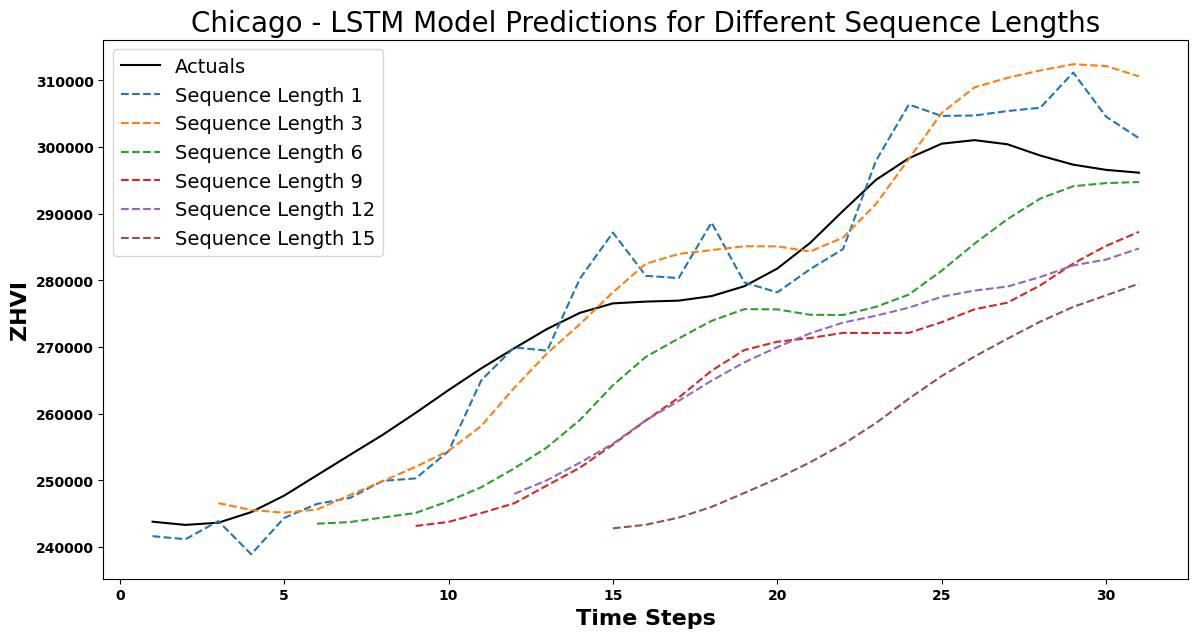

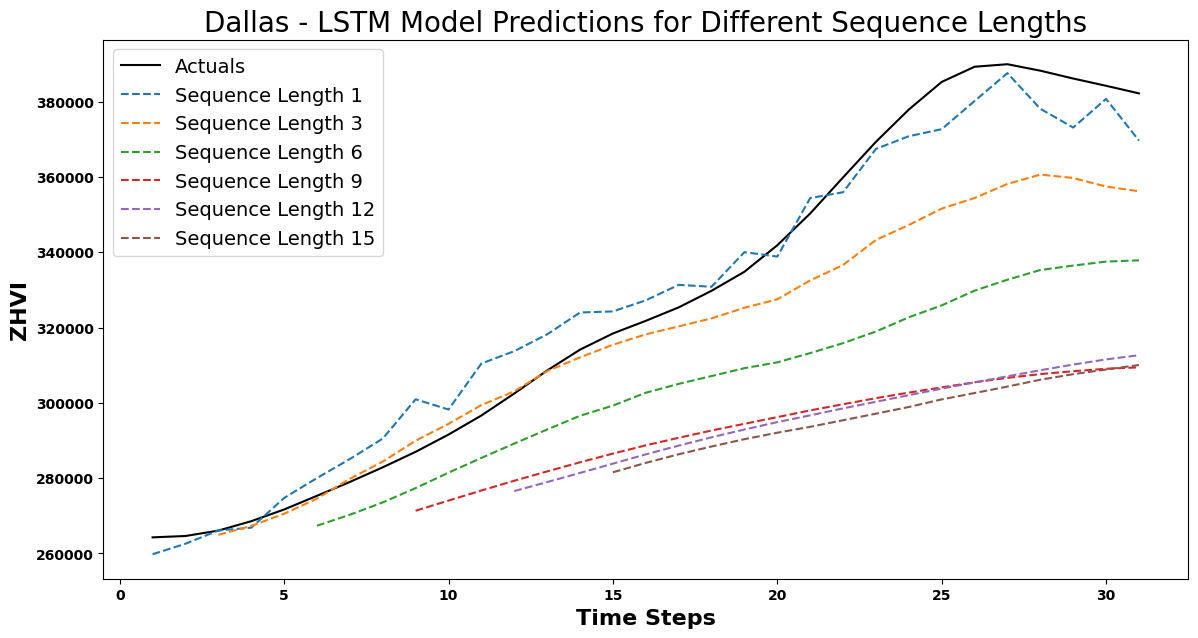

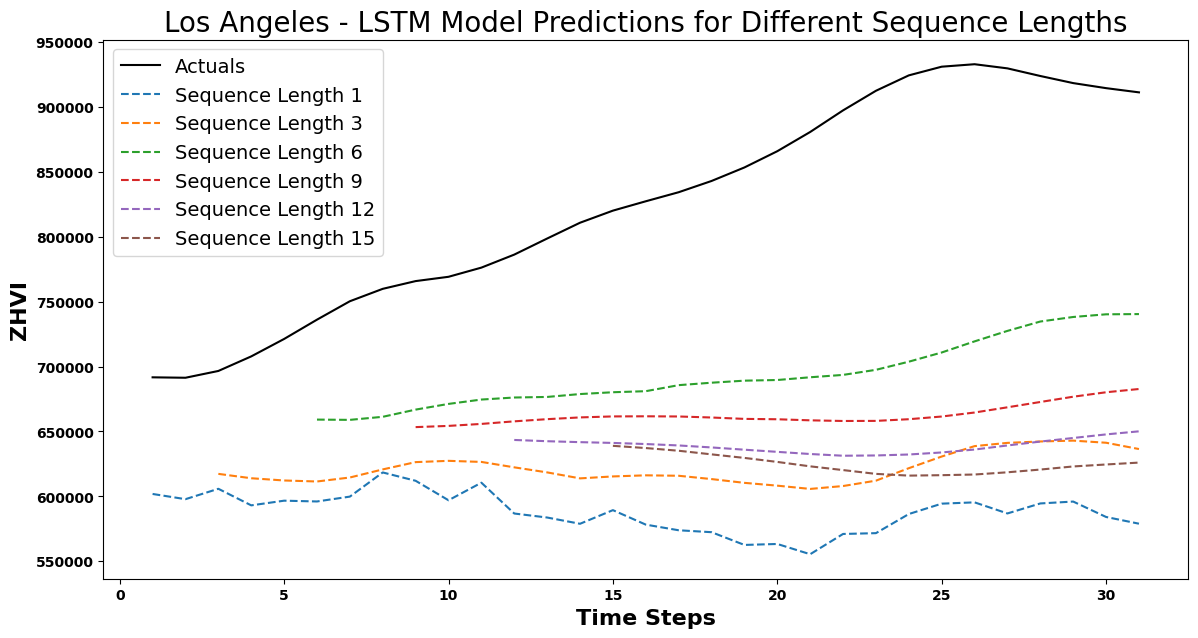

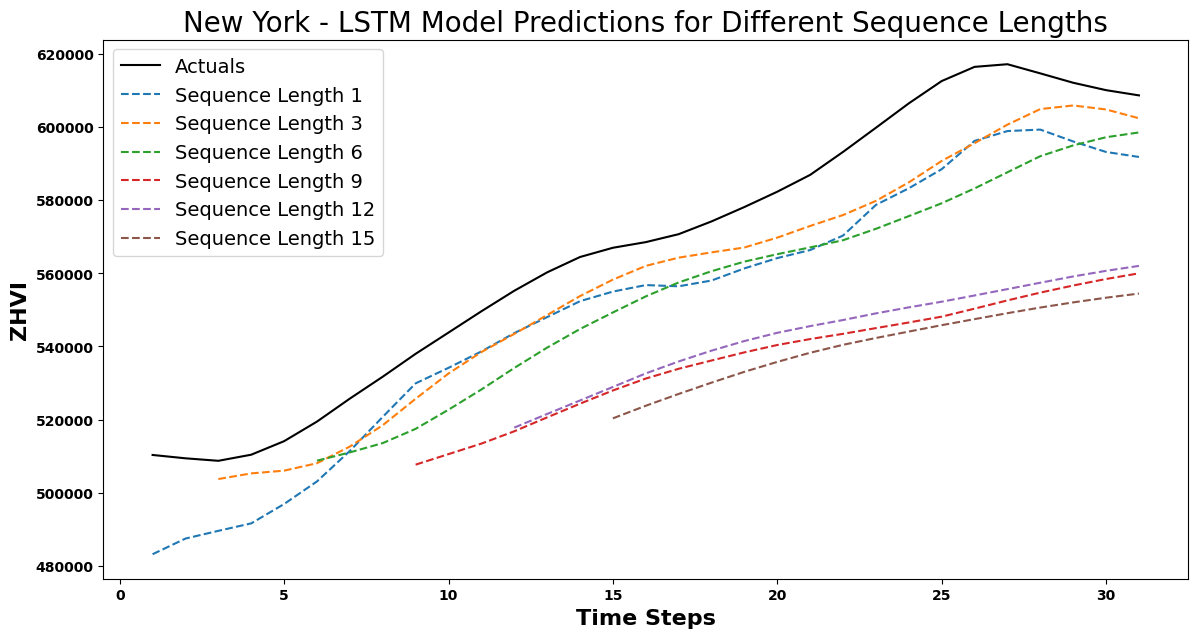

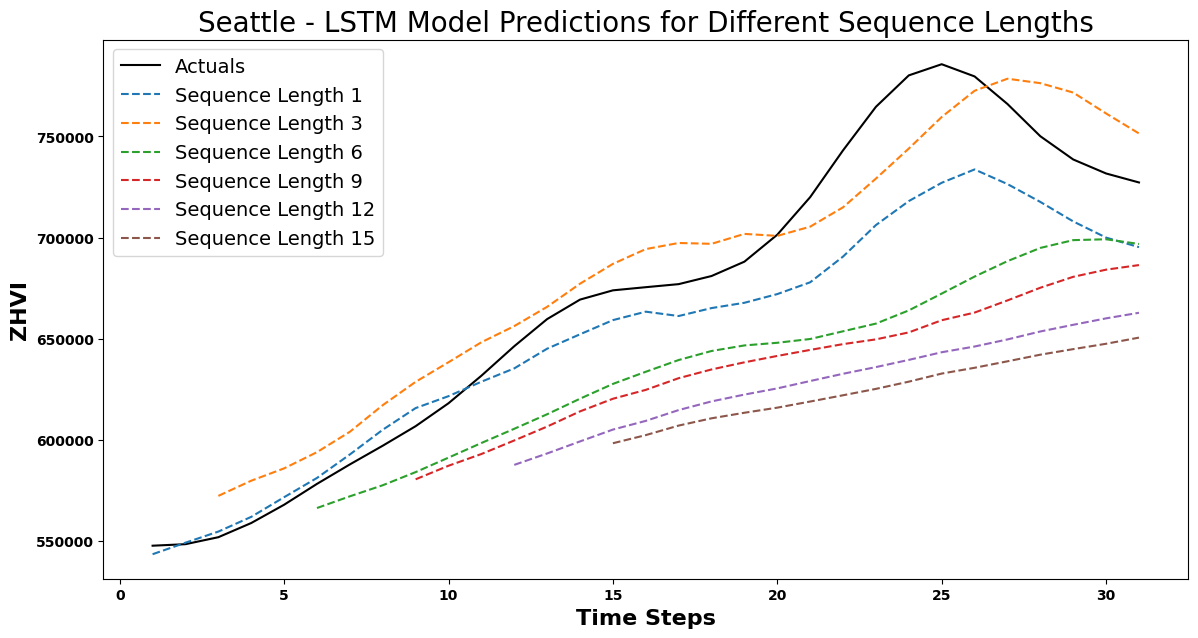

In [13]:
# Plotting the results for each city
for city in merged_df['City'].unique():
    plt.figure(figsize=(14, 7))
    plt.title(f'{city} - LSTM Model Predictions for Different Sequence Lengths', fontsize=20)
    actuals_plotted = False
    for seq_len in sequence_lengths:
        if not actuals_plotted:
            plt.plot(range(seq_len, seq_len + len(results[city][seq_len]['actuals'])), results[city][seq_len]['actuals'], label='Actuals', color='black')
            actuals_plotted = True
        plt.plot(range(seq_len, seq_len + len(results[city][seq_len]['predictions'])), results[city][seq_len]['predictions'], label=f'Sequence Length {seq_len}', linestyle='--')
    plt.xlabel('Time Steps', fontsize=16, fontweight='bold')
    plt.ylabel('ZHVI',  fontsize=16, fontweight='bold')
    plt.xticks(fontweight='bold')
    plt.yticks(fontweight='bold')
    plt.legend(fontsize=14)
    plt.show()

#### <center> Based on the result we can see most of the city shows 3 month windows size performs well